# VAE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
kernel_size = 3
stride = 1
padding = 1
init_kernel = 2 # initial number of filters

In [3]:
def get_binary(X):
    return torch.tensor((X>=0.5)*1,dtype=torch.float)

In [4]:
class ConvVAE(nn.Module):
    def __init__(self) : 
        super(ConvVAE, self).__init__()

        # ======= ENcoder MLP
        self.enc_layer_1 = nn.Linear(28*28*8, 100)
        self.enc_layer_2 = nn.Linear(100, 20*2)  # the covariance matrix is diagonal so we need "dim_lat" element for the the cov matrix and dim_lat for the mean of the normal ditribution
        self.enc1 = nn.Conv2d(1, 2, kernel_size=3, stride=1, padding=1)
        self.enc2 = nn.Conv2d(2, 4, kernel_size=3, stride=1, padding=1)
        self.enc3 = nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1)


        # ======= Decoder MLP
        self.dec_layer_1 = nn.Linear(20, 100)
        self.dec_layer_2 = nn.Linear(100, 8*22*22)
        self.dec1 = nn.ConvTranspose2d(8,4, kernel_size=3, stride=1)
        self.dec2 = nn.ConvTranspose2d(4,2, kernel_size=3, stride=1)
        self.dec3 = nn.ConvTranspose2d(2,1, kernel_size=3, stride=1)
        

    # ===== Parametrization trick
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5*log_var) 
        eps = torch.randn_like(std) 
        sample = mu + (eps * std) 
        return sample
    def encode(self,x):
        output = torch.relu(self.enc1(x))
        output = torch.relu(self.enc2(output))
        output = torch.relu(self.enc3(output))
        output=output.view(output.size(0), -1)
        output= torch.relu(self.enc_layer_1(output))
        output= self.enc_layer_2(output).view(-1, 2, 20)
        # We seprate the lattent variable into 2 variable : the mean + cov matrix
        mu = output[:, 0, :] 
        log_var = output[:, 1, :]

        z = self.reparameterize(mu, log_var)
        return z, mu, log_var
    def decode(self,z):
        image= torch.relu(self.dec_layer_1(z))
        image= torch.relu(self.dec_layer_2(image)).view(z.size(0),-1,22,22)
        image= torch.relu(self.dec1(image))
        image= torch.relu(self.dec2(image))
        return torch.sigmoid(self.dec3(image))
    def forward(self, input) :
        z,mu,log_var=self.encode(input)
        image=self.decode(z)
        return image, mu, log_var

In [5]:
from tqdm.auto import tqdm
from torchvision import transforms, datasets
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import matplotlib.pyplot as plt
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import torch.nn.functional as F

import scipy.io
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
from torchvision.utils import save_image

In [6]:
batch_size = 400
lr = 0.001
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
train_data = datasets.MNIST('data',train=True,download=True,transform=transforms.ToTensor(),target_transform=None)
val_data=datasets.MNIST('data',train=False,download=True,transform=transforms.ToTensor(),target_transform=None)
train_loader = DataLoader(train_data,shuffle=True,batch_size=batch_size)
val_loader = DataLoader(val_data,shuffle=False,batch_size=batch_size)

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw
Processing...
Done!


/opt/conda/lib/python3.7/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1603729138878/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [8]:
model = ConvVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.BCELoss(reduction='sum')

#### Before training
Here the threshold value is 0.4

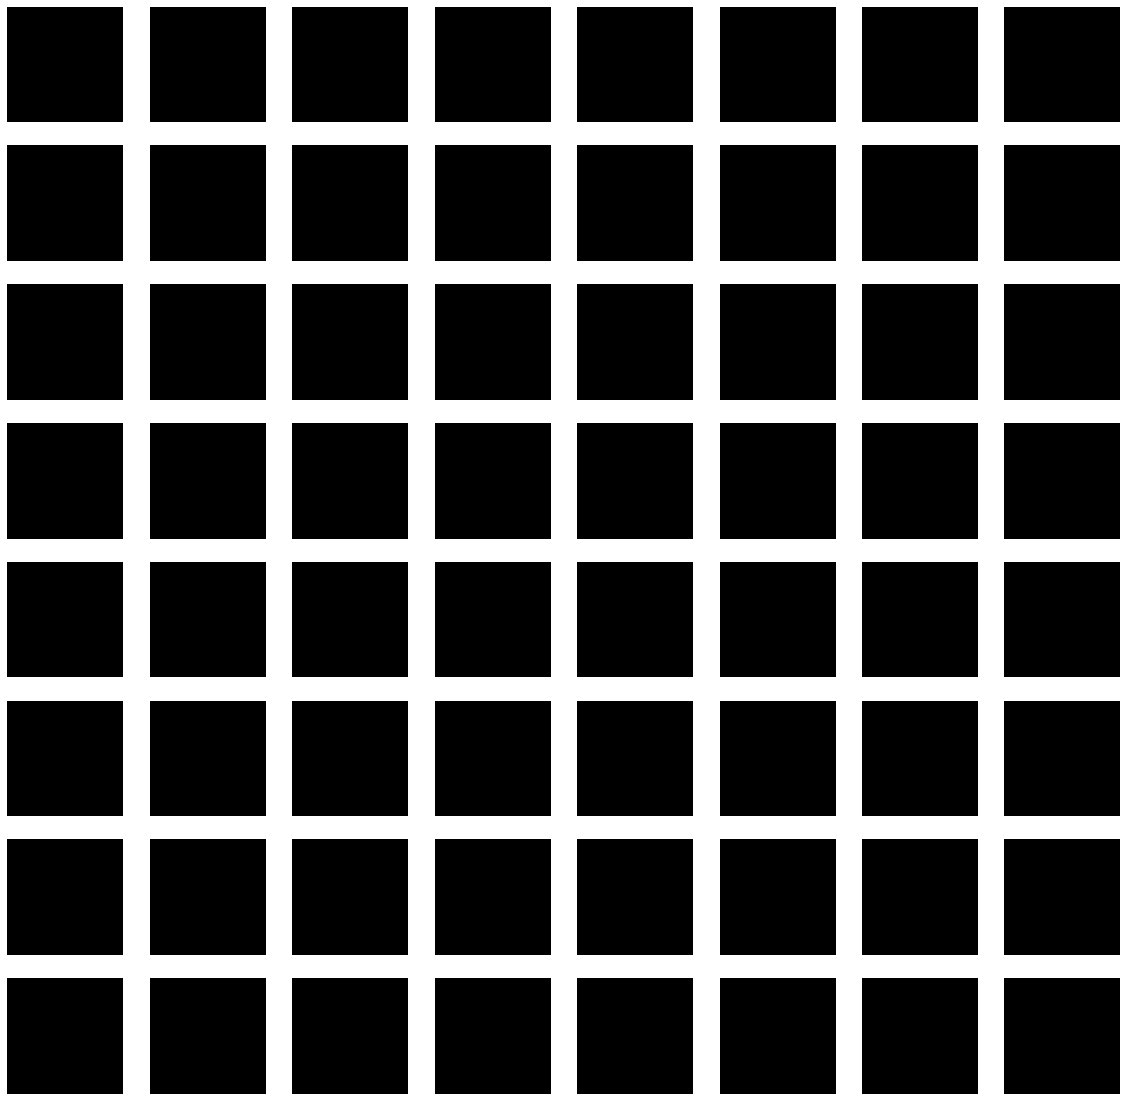

In [9]:
cov = [[0 for k in range(20)] for i in range(20)]
for i in range(20)  :
  cov[i][i] = 1
fig,axs = plt.subplots(8,8,figsize = (20,20))
for i in range(64) :
    rng = np.random.default_rng()
    x = rng.multivariate_normal([0 for k in range(20)], cov)
    x = np.reshape(x,(1,20))
    latent = torch.tensor(x).float().to(device)
    reconstruction = model.decode(latent)
    A=np.array(torch.reshape(reconstruction, (28,28) ).detach().cpu())
    axs[i//8][i%8].imshow((A>=0.4)*1,cmap='gray')
    axs[i//8][i%8].axis('off')

In [10]:
def final_loss(bce_loss, mu, logvar):
    BCE = bce_loss 
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

In [11]:
def fit(model, dataloader):
    model.train()
    running_loss = 0.0
    for i, data in enumerate(dataloader):
        data= data[0]
        data = data.to(device)
        data = get_binary(data)
        optimizer.zero_grad()
        reconstruction, mu, logvar = model(data)
        bce_loss = criterion(reconstruction, data)
        loss = final_loss(bce_loss, mu, logvar)
        loss.backward()
        running_loss += loss.item()
        optimizer.step()
    train_loss = running_loss/len(dataloader.dataset)
    return train_loss

In [12]:
def validate(model, dataloader):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for i, data in enumerate(dataloader):
            
            data= data[0]
            data = data.to(device)
            data = get_binary(data)
            reconstruction, mu, logvar = model(data)
            bce_loss = criterion(reconstruction, data)
            loss = final_loss(bce_loss, mu, logvar)
            running_loss += loss.item()
        
            # save the last batch input and output of every epoch
            if i == int(len(val_data)/dataloader.batch_size) - 1:
                num_rows = 8
                both = torch.cat((data[:8], 
                                  reconstruction[:8]))
                #save_image(both.cpu(), f"../outputs/output{epoch}.png", nrow=num_rows)

    val_loss = running_loss/len(dataloader.dataset)
    return val_loss

In [13]:
train_loss = []
val_loss = []
epochs = 10
for epoch in range(10):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Train Loss: 337.4492
Val Loss: 219.1236
Epoch 2 of 10
Train Loss: 196.7232
Val Loss: 171.4476
Epoch 3 of 10
Train Loss: 152.6563
Val Loss: 136.4090
Epoch 4 of 10
Train Loss: 127.8329
Val Loss: 119.4017
Epoch 5 of 10
Train Loss: 116.9297
Val Loss: 112.4702
Epoch 6 of 10
Train Loss: 111.4205
Val Loss: 108.6645
Epoch 7 of 10
Train Loss: 107.8280
Val Loss: 105.2792
Epoch 8 of 10
Train Loss: 104.9688
Val Loss: 102.4487
Epoch 9 of 10
Train Loss: 102.0551
Val Loss: 100.1593
Epoch 10 of 10
Train Loss: 99.7249
Val Loss: 97.8898


#### After 10 epochs

In [14]:
cov = [[0 for k in range(20)] for i in range(20)]
for i in range(20)  :
  cov[i][i] = 1

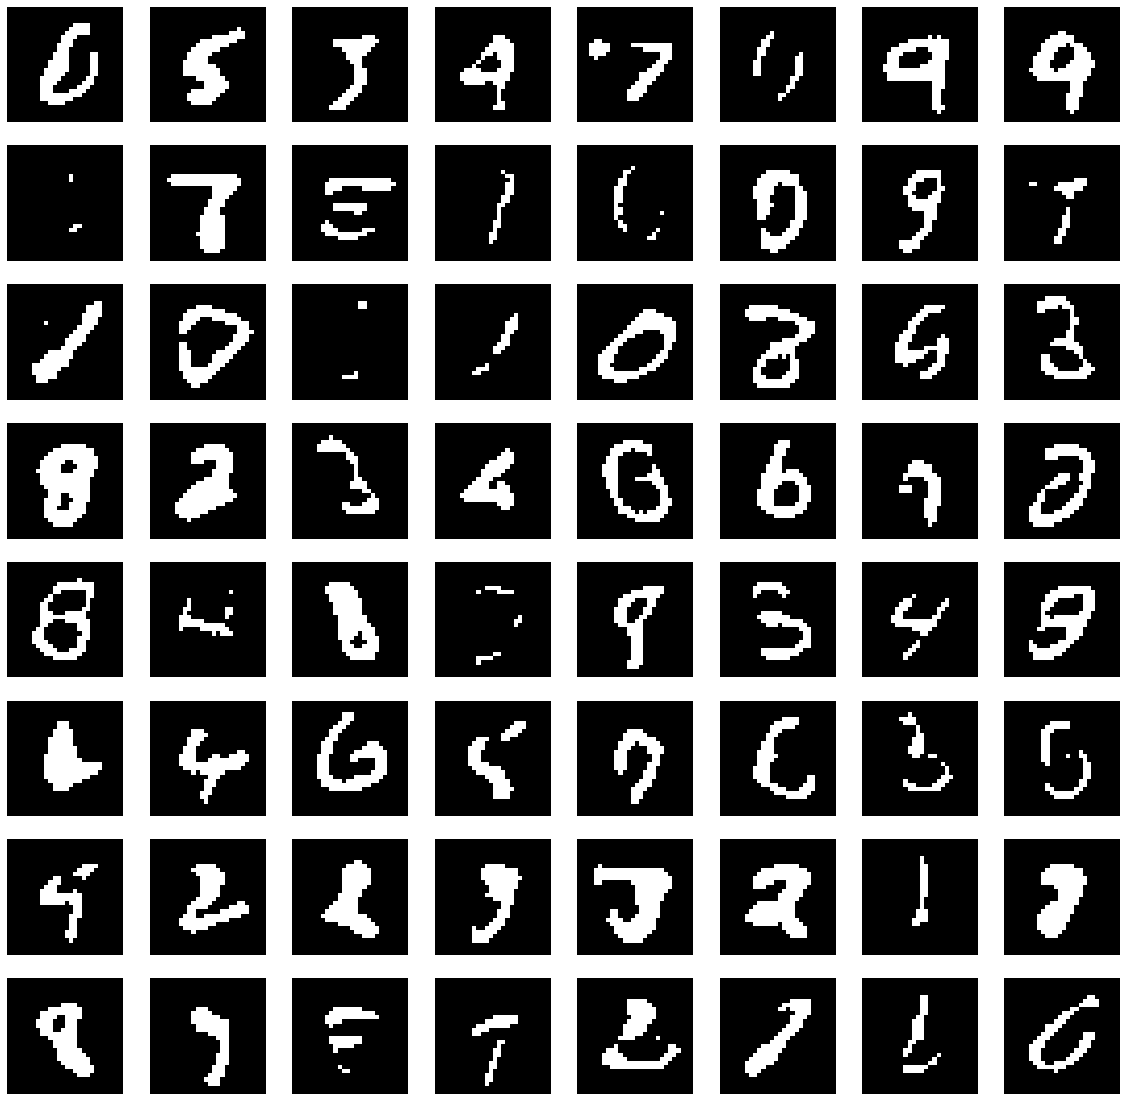

In [15]:
fig,axs = plt.subplots(8,8,figsize = (20,20))
for i in range(64) :
    rng = np.random.default_rng()
    x = rng.multivariate_normal([0 for k in range(20)], cov)
    x = np.reshape(x,(1,20))
    latent = torch.tensor(x).float().to(device)
    reconstruction = model.decode(latent)
    A=np.array(torch.reshape(reconstruction, (28,28) ).detach().cpu())
    axs[i//8][i%8].imshow((A>=0.5)*1,cmap='gray')
    axs[i//8][i%8].axis('off')

#### After 80 epochs

In [16]:
train_loss = []
val_loss = []
for epoch in range(70):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_loss = fit(model, train_loader)
    val_epoch_loss = validate(model, val_loader)
    train_loss.append(train_epoch_loss)
    val_loss.append(val_epoch_loss)
    print(f"Train Loss: {train_epoch_loss:.4f}")
    print(f"Val Loss: {val_epoch_loss:.4f}")

Epoch 1 of 10


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


Train Loss: 97.9451
Val Loss: 97.4385
Epoch 2 of 10
Train Loss: 96.5650
Val Loss: 95.5835
Epoch 3 of 10
Train Loss: 95.5126
Val Loss: 94.6993
Epoch 4 of 10
Train Loss: 94.5922
Val Loss: 94.1450
Epoch 5 of 10
Train Loss: 93.8256
Val Loss: 93.7374
Epoch 6 of 10
Train Loss: 93.0705
Val Loss: 92.9218
Epoch 7 of 10
Train Loss: 92.5939
Val Loss: 92.3630
Epoch 8 of 10
Train Loss: 92.0677
Val Loss: 92.1289
Epoch 9 of 10
Train Loss: 91.6164
Val Loss: 91.9748
Epoch 10 of 10
Train Loss: 91.1254
Val Loss: 91.3861
Epoch 11 of 10
Train Loss: 90.8832
Val Loss: 91.3940
Epoch 12 of 10
Train Loss: 90.4683
Val Loss: 91.0614
Epoch 13 of 10
Train Loss: 90.0582
Val Loss: 90.7359
Epoch 14 of 10
Train Loss: 89.8035
Val Loss: 90.5026
Epoch 15 of 10
Train Loss: 89.5636
Val Loss: 90.1627
Epoch 16 of 10
Train Loss: 89.2737
Val Loss: 89.9033
Epoch 17 of 10
Train Loss: 89.0006
Val Loss: 90.1412
Epoch 18 of 10
Train Loss: 88.7294
Val Loss: 90.0223
Epoch 19 of 10
Train Loss: 88.6361
Val Loss: 89.4680
Epoch 20 of 10
T

In [17]:
cov = [[0 for k in range(20)] for i in range(20)]
for i in range(20)  :
  cov[i][i] = 1

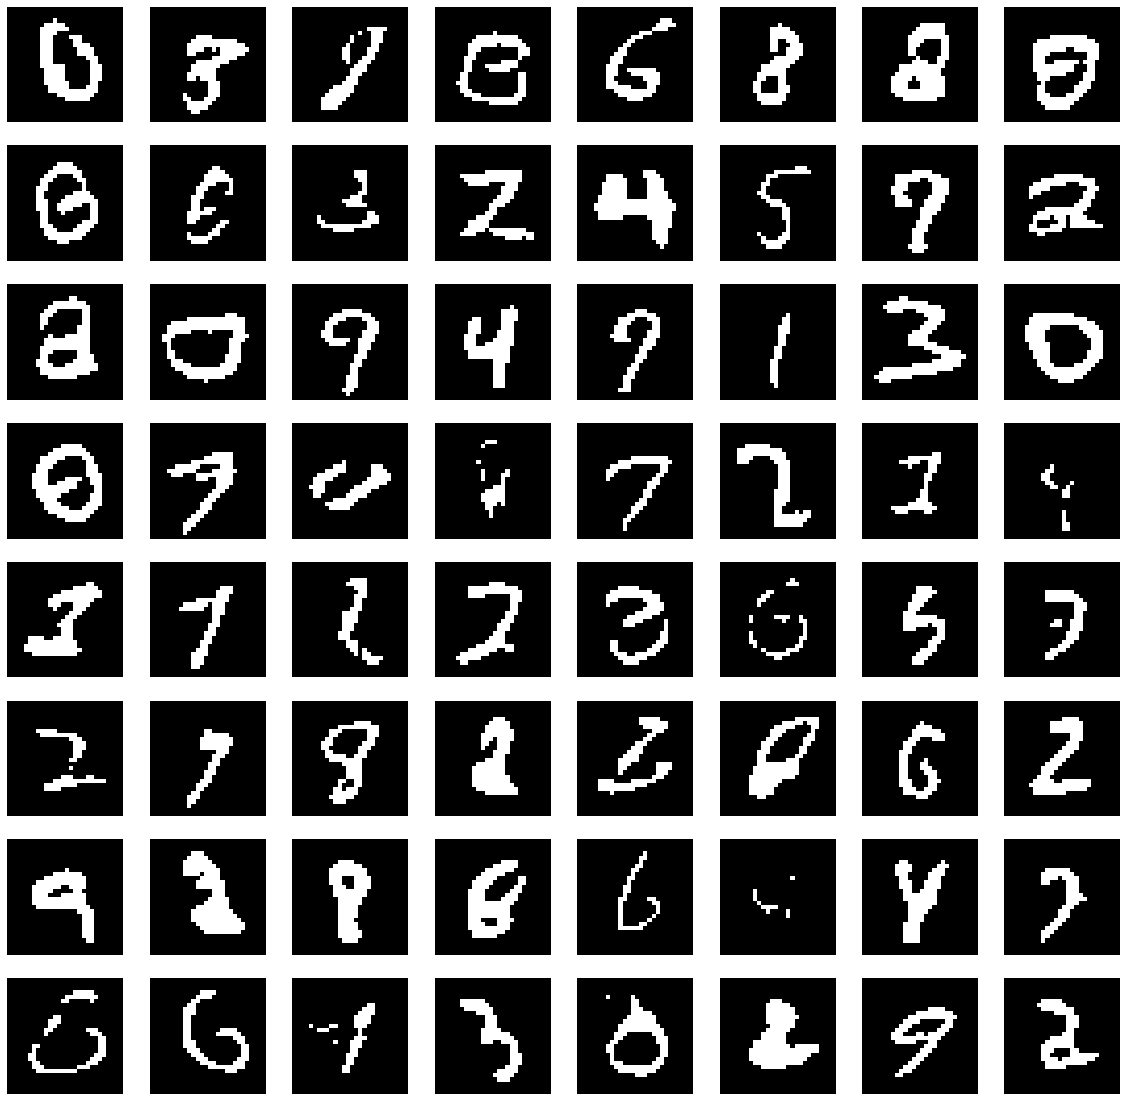

In [18]:
fig,axs = plt.subplots(8,8,figsize = (20,20))
for i in range(64) :
    rng = np.random.default_rng()
    x = rng.multivariate_normal([0 for k in range(20)], cov)
    x = np.reshape(x,(1,20))
    latent = torch.tensor(x).float().to(device)
    reconstruction = model.decode(latent)
    A=np.array(torch.reshape(reconstruction, (28,28) ).detach().cpu())
    axs[i//8][i%8].imshow((A>=0.5)*1,cmap='gray')
    axs[i//8][i%8].axis('off')

# Variational Auto Encoders